 # Introduction
 
 I've used CNN to perform Image Classification on the Brain Tumor dataset.
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.
Therefore, I'm going to use the concept of Transfer Learning to train the model to get really accurate results.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import cv2
import tensorflow as tf
from PIL import Image

### Data Preparation

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


In [ ]:
from tqdm import tqdm
X_train=[]
y_train=[]
img_size = 150
for i in labels:
  folderPath = os.path.join('/content/drive/MyDrive/colab stuff/Brain Tumor','Training',i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(img_size,img_size))
    X_train.append(img)
    y_train.append(i)


for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/colab stuff/Brain Tumor','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(img_size,img_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 74/74 [00:00<00:00, 89.62it/s]


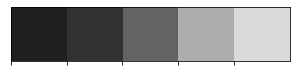

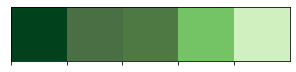

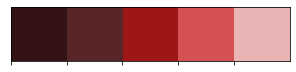

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

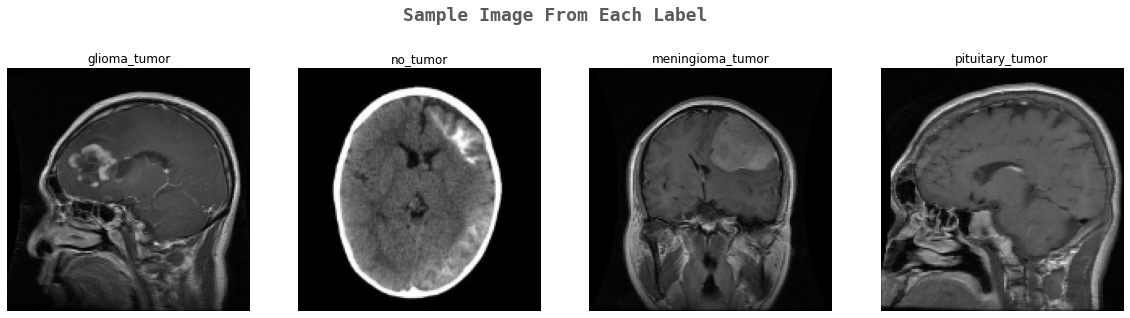

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [ ]:
X_train.shape

(3264, 150, 150, 3)

####Image Data Augmentation: 
  Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. It uses techniques such as flipping, zooming, padding, cropping, etc.

Data augmentation makes the model more robust to slight variations, and hence prevents the model from overfitting.

To do so using Keras, we use the function ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range = 30, width_shift_range=0.1, height_shift_range=0.1,zoom_range=0.2, horizontal_flip=True)

datagen.fit(X_train)
X_train.shape

(3264, 150, 150, 3)

Dividing the Dataset into training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=101)

Performing one Hot Encoding on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

### Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the EfficientNetB0 model which will use the weights from the ImageNet dataset.

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint


effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size,img_size,3))

GlobalAveragePooling2D -> 
  
  This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while pooling. This really helps in decreasing the computational load on the machine while training.

Dropout -> 
  
  This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The rate parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

Dense -> 
  
  This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

We finally compile our model

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

Callbacks -> 

  Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using TensorBoard, ModelCheckpoint and ReduceLROnPlateau callback functions

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

### Training the model

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/12
83/83 [==============================] - 324s 4s/step - loss: 0.4556 - accuracy: 0.8320 - val_loss: 0.8132 - val_accuracy: 0.7449

Epoch 00001: val_accuracy improved from -inf to 0.74490, saving model to effnet.h5
Epoch 2/12
83/83 [==============================] - 310s 4s/step - loss: 0.1627 - accuracy: 0.9414 - val_loss: 0.2856 - val_accuracy: 0.8946

Epoch 00002: val_accuracy improved from 0.74490 to 0.89456, saving model to effnet.h5
Epoch 3/12
83/83 [==============================] - 304s 4s/step - loss: 0.1266 - accuracy: 0.9580 - val_loss: 0.4811 - val_accuracy: 0.9048

Epoch 00003: val_accuracy improved from 0.89456 to 0.90476, saving model to effnet.h5
Epoch 4/12
83/83 [==============================] - 308s 4s/step - loss: 0.1160 - accuracy: 0.9614 - val_loss: 0.2603 - val_accuracy: 0.9286

Epoch 00004: val_accuracy improved from 0.90476 to 0.92857, saving model to effnet.h5
Epoch 5/12
83/83 [==============================] - 310s 4s/step - loss: 0.0742 - accuracy:

### Prediction
I've used the argmax function as each row from the prediction array contains four values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 4 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

### Evaluation
In this,

0 - Glioma Tumor

1 - No Tumor

2 - Meningioma Tumor

3 - Pituitary Tumor

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        93
           1       0.96      1.00      0.98        51
           2       0.99      0.96      0.97        96
           3       0.99      1.00      0.99        87

    accuracy                           0.98       327
   macro avg       0.98      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327



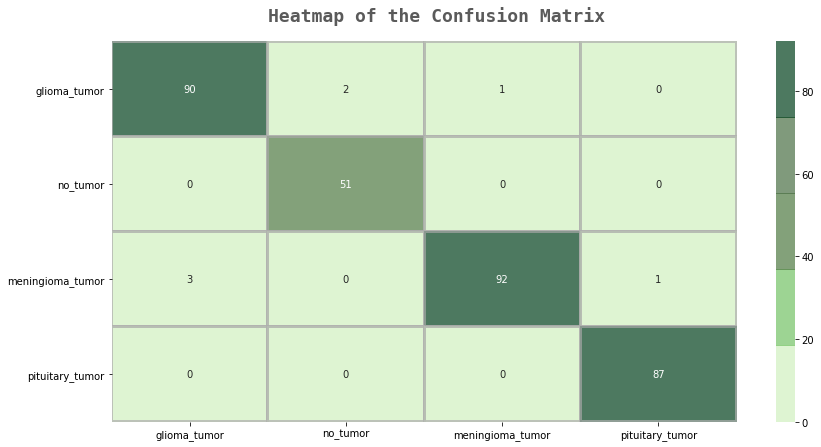

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'it is a {p}')

In [ ]:
import ipywidgets as widgets
from IPython.display import display,clear_output
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

The model predicts that there is no tumor


In [ ]:
model.save('tumor_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
new_model = tf.keras.models.load_model('tumor_model.h5')


In [ ]:
"""img = Image.open('images.jpg')
opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
img = cv2.resize(opencvImage,(150,150))
img = img.reshape(1,150,150,3)
p = new_model.predict(img)
p = np.argmax(p,axis=1)[0]

if p==0:
     p='Glioma Tumor'
elif p==1:
     print('The model predicts that there is no tumor')
elif p==2:
     p='Meningioma Tumor'
else:
     p='Pituitary Tumor'

if p!=1:
    print(f'it is a {p}')"""

"img = Image.open('images.jpg')\nopencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)\nimg = cv2.resize(opencvImage,(150,150))\nimg = img.reshape(1,150,150,3)\np = new_model.predict(img)\np = np.argmax(p,axis=1)[0]\n\nif p==0:\n     p='Glioma Tumor'\nelif p==1:\n     print('The model predicts that there is no tumor')\nelif p==2:\n     p='Meningioma Tumor'\nelse:\n     p='Pituitary Tumor'\n\nif p!=1:\n    print(f'it is a {p}')"